# Telco Churn Prediction

## 1. Introduction

### [1.1 Imports](#imports)

### [1.2 Data Setup](#data-setup)

## 2. Modelling

### [2.1 Logistic Regression (unscaled)](#logistic-regression-unscaled)

### [2.15 Logistic Regression (scaled)](#logistic-regression-scaled)

### [2.2 Random Forest](#random-forest)

### [2.3 XGBoost (tuned)](#xgboost-tuned)

### [2.4 Model Performance Summary](#model-performance-summary)

## 3. Model Explainability

### [3.1 Feature Importance](#feature-importance)

### [3.2 Permutation Importance](#permutation-importance)

### [3.3 SHAP Summary Plot](#shap-summary-plot)

### [3.4 SHAP Dependence Plot Tenure vs Churn Risk](#shap-dependence-plot-tenure-vs-churn-risk)

### [3.5 SHAP Dependence Plot monthly charges vs Churn Risk](#shap-dependence-plot-monthly-charges-vs-churn-risk)

## 4. Conclusions

### [4.1 Summary of Findings](#summary-of-findings)

### [4.2 Business Implications](#business-implications)

### [4.3 Next Steps](#next-steps)

## 1. Introduction

### Imports

In [ ]:
import pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,shap,warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,plot_importance
df = pd.read_csv('../data/processed/telco_churn_clean_v1.csv')
warnings.filterwarnings('ignore')

### Data Setup

In [60]:
features = df.drop(columns=['Churn','customerID'])
# need to encode since scaling is not done
features_encoded = pd.get_dummies(features, drop_first=True)
target = df['Churn']
target_encoded = target.map({'Yes':1,'No':0})
# stratify to maintain Churn rate in all datasets
features_train,features_test,target_train,target_test=train_test_split(
    features_encoded,target_encoded,test_size=0.2,random_state=42,stratify=target
    )

features_train.value_counts()

tenure  MonthlyCharges  TotalCharges  gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  PhoneService_Yes  MultipleLines_No phone service  MultipleLines_Yes  InternetService_Fiber optic  InternetService_No  OnlineSecurity_No internet service  OnlineSecurity_Yes  OnlineBackup_No internet service  OnlineBackup_Yes  DeviceProtection_No internet service  DeviceProtection_Yes  TechSupport_No internet service  TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  StreamingMovies_No internet service  StreamingMovies_Yes  Contract_One year  Contract_Two year  PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  PaymentMethod_Mailed check
1       20.20           20.20         1            0                  0            0               1                 0                               0                  0                            1                   1                                   0                   1                         

## 2. Modelling

In [61]:
def get_model_stats(model,predictions):
    print("Accuracy:", accuracy_score(target_test, predictions))
    print("Precision:", precision_score(target_test, predictions, pos_label=1))
    print("Recall:", recall_score(target_test, predictions, pos_label=1))
    print("F1 Score:", f1_score(target_test, predictions, pos_label=1))
    probs = model.predict_proba(features_test)[:,1]
    print("ROC AUC",roc_auc_score(target_test,probs))

### Logistic Regression (unscaled)

In [62]:
model = LogisticRegression(max_iter=1000)
model.fit(features_train,target_train)
predictions = model.predict(features_test)

get_model_stats(model,predictions)

Accuracy: 0.8031272210376688
Precision: 0.6465256797583081
Recall: 0.5721925133689839
F1 Score: 0.6070921985815603
ROC AUC 0.8364700187916405


### Logistic Regression (scaled)

In [63]:
# scaled version
# start by scaling data
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)
model = LogisticRegression(max_iter=1000)
model.fit(features_train_scaled,target_train)
predictions = model.predict(features_test_scaled)

get_model_stats(model,predictions)

Accuracy: 0.8038379530916845
Precision: 0.6475903614457831
Recall: 0.5748663101604278
F1 Score: 0.6090651558073654
ROC AUC 0.39258351408855363


### Random Forest

In [64]:
# tree-based model
model = RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(features_train,target_train)
predictions = model.predict(features_test)

get_model_stats(model,predictions)

Accuracy: 0.7853589196872779
Precision: 0.6216216216216216
Recall: 0.4919786096256685
F1 Score: 0.5492537313432836
ROC AUC 0.8168449197860962


### XGBoost (tuned)

In [65]:
xgb_model = XGBClassifier(
    n_estimators=100,
    random_state=42,
    learning_rate=0.1,
    max_depth=2,
    subsample=0.95,
    colsample_bytree=0.8,
    use_label_encoder=False,eval_metric='logloss'
    )
xgb_model.fit(features_train,target_train)
predictions = xgb_model.predict(features_test)

get_model_stats(xgb_model,predictions)


Accuracy: 0.7974413646055437
Precision: 0.6468646864686468
Recall: 0.5240641711229946
F1 Score: 0.5790251107828656
ROC AUC 0.8409647410843243


### Model Performance Summary

| Model                            | ROC AUC | F1 Score | Precision | Recall |
|----------------------------------|---------|----------|-----------|--------|
| Logistic Regression (unscaled)   | 0.80    | 0.61     | 0.65      | 0.57   |
| Logistic Regression (scaled)     | 0.39    | 0.61     | 0.65      | 0.57   |
| Random Forest                    | 0.82    | 0.55     | 0.62      | 0.49   |
| XGBoost (tuned)                  | 0.84    | 0.58     | 0.65      | 0.52   |

> #### XGBoost Selected 

## 3. Model Explainability

### Feature Importance

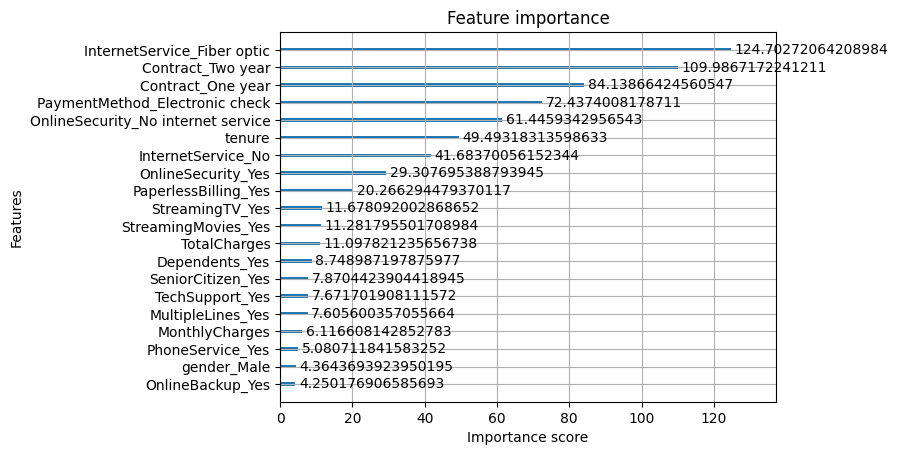

In [66]:
plot_importance(xgb_model,importance_type='gain',max_num_features=20)
plt.show()

### Permutation Importance

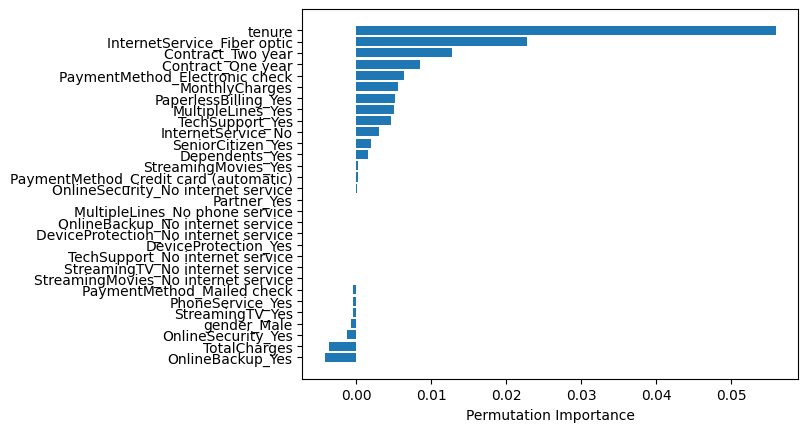

In [67]:
perm_importance = permutation_importance(xgb_model,features_test,target_test,n_repeats=10,random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(range(len(sorted_idx)),perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), features_test.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [68]:
# Create explainer for your fitted XGBoost model
explainer = shap.Explainer(xgb_model, features_test)

# Compute SHAP values
shap_values = explainer(features_test)

### SHAP Summary Plot

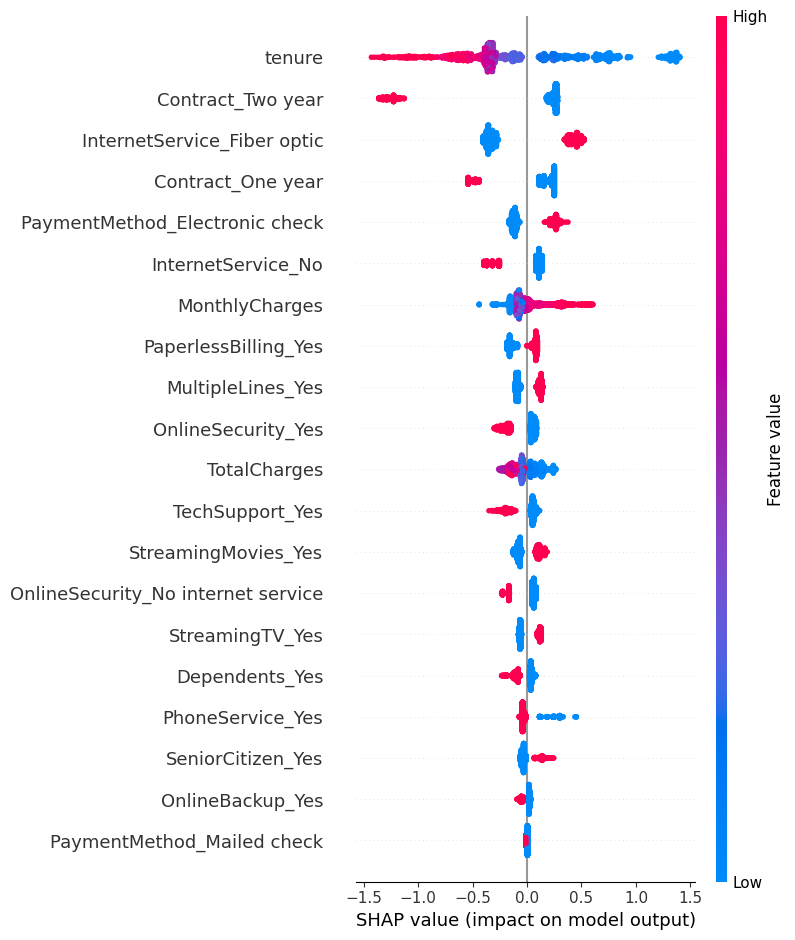

In [69]:
# Summary plot (feature importance + direction)
shap.summary_plot(shap_values, features_test)

In [70]:
# Create explainer for your fitted XGBoost model
explainer = shap.Explainer(xgb_model, features_test)

# Compute SHAP values
shap_values = explainer(features_test)

### SHAP Dependence Plot: Tenure vs Churn Risk

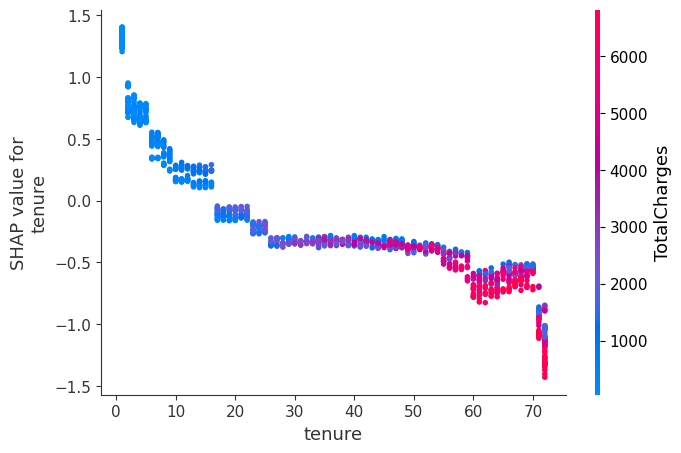

In [71]:
shap.dependence_plot('tenure',shap_values.values,features_test)

## SHAP Dependence Plot: Monthly Charges vs Churn Risk

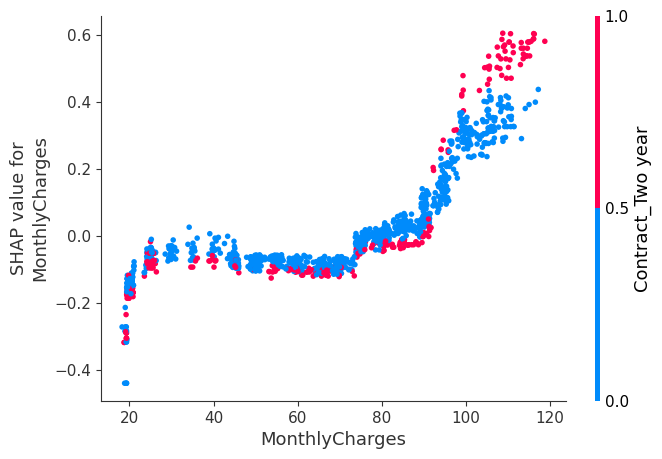

In [72]:
shap.dependence_plot('MonthlyCharges',shap_values.values,features_test)

## SHAP Waterfall Plot-Highest Churn risk customer

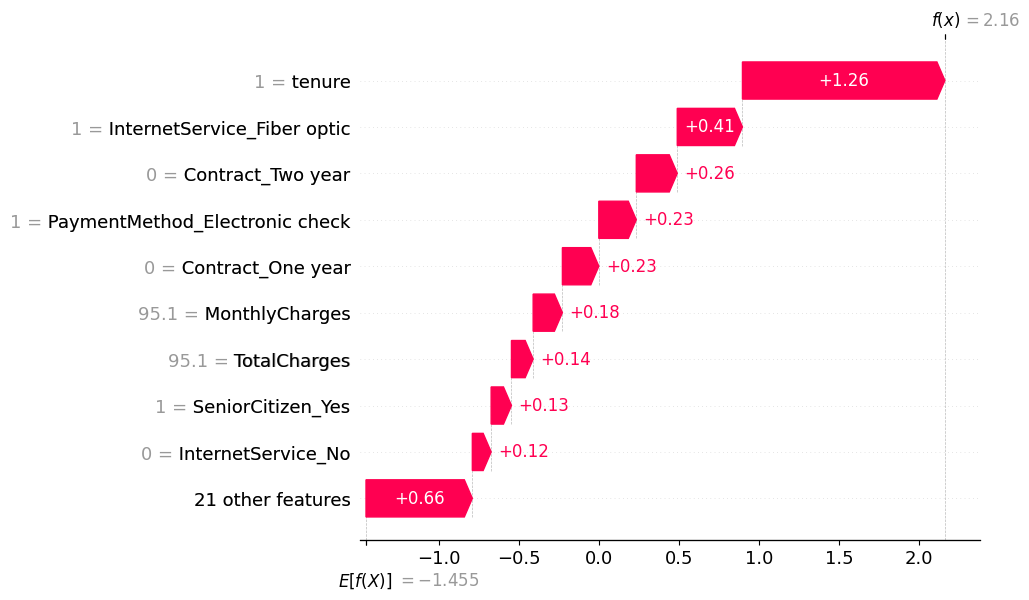

In [73]:
highest_risk_id= probs.argmax()
shap.waterfall_plot(shap_values[highest_risk_id])

## 4. Conclusions

### Summary of Findings

- XGBoost model achieved an ROC AUC of 0.84 outperforming Logistic Regression (scaled/unscaled) and Random Forest

- The most impactful driver of churn were:
    - Tenure - shorter tenure led increased churn risk
    - Contract type - month-to-month contracts had higher risk of churn
    - Internet Service - customers with no fibre optics tended to churn more
    - Monthly Charges - customers with higher charges tend to churn more

### Business Implications
- The model can help the business identify customers who are likely to churn.
- Customers with short term contracts or high monthly charges are prime targets for retention offers.
- Encouraging customers to switch to longer term contracts may reduce churn rates.

### Next Steps
- Deploy model and provide to retention team as a scoring tool.
- Monitor model performance over time.
